In [1]:
import csv
import collections

import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt

%matplotlib inline

## Read entrez gene

In [2]:
# read entrez genes
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/5352b31e04ec136e99d25a0ba63e8867aa71b69f/data/genes-human.tsv'
entrez_df = pandas.read_table(url, dtype={'GeneID': str})
human_genes = set(entrez_df.GeneID)
human_coding_genes = set(entrez_df[entrez_df.type_of_gene == 'protein-coding'].GeneID)

## GMT functions

In [3]:
def read_gmt(path):
    read_file = open(path)
    reader = csv.reader(read_file, delimiter='\t')
    for row in reader:
        name = row[0]
        description = row[1]
        genes = set(row[2:])
        yield name, description, genes
    read_file.close()

## Resource downloads

In [4]:
# download wikipathways
url = 'http://www.pathvisio.org/data/bots/gmt/wikipathways.gmt'
! wget --timestamping --no-verbose --directory-prefix=download $url

# download MSigDB 5.1 pathways
url = 'https://www.broadinstitute.org/gsea/resources/msigdb/5.1/c2.cp.v5.1.entrez.gmt'
! wget --timestamping --no-verbose --directory-prefix=download $url

Last-modified header missing -- time-stamps turned off.
2016-02-04 16:15:35 URL:http://software.broadinstitute.org/gsea/resources/msigdb/5.1/c2.cp.v5.1.entrez.gmt [514074/514074] -> "download/c2.cp.v5.1.entrez.gmt" [1]


## Parse WikiPathways

In [5]:
gmt_generator = read_gmt('download/wikipathways.gmt')
wikipath_df = pandas.DataFrame(gmt_generator, columns = ['name', 'description', 'genes'])
len(wikipath_df)

1313

In [6]:
# Remove genes absent from our entrez gene version
for genes in wikipath_df.genes:
    genes &= human_genes
wikipath_df = wikipath_df[wikipath_df.genes.map(bool)]
len(wikipath_df)

296

In [7]:
wikipath_df.head()

,name,description,genes
950,Tryptophan metabolism%WikiPathways_20160205%WP...,http://www.wikipathways.org/instance/WP465_r79226,"{1892, 130013, 125061, 3028, 1588, 216, 26, 51..."
951,Steroid Biosynthesis%WikiPathways_20160205%WP4...,http://www.wikipathways.org/instance/WP496_r69016,"{3284, 1586, 3292, 3294, 51478, 1369, 3293, 21..."
952,Arylamine metabolism%WikiPathways_20160205%WP6...,http://www.wikipathways.org/instance/WP694_r67062,"{6799, 10, 54657, 6817, 54600, 1544}"
953,Regulation of Actin Cytoskeleton%WikiPathways_...,http://www.wikipathways.org/instance/WP51_r79977,"{2264, 9564, 2263, 28964, 5289, 26291, 10787, ..."
954,Interleukin-11 Signaling Pathway%WikiPathways_...,http://www.wikipathways.org/instance/WP2332_r7...,"{5594, 2534, 6774, 1385, 3265, 1147, 3551, 367..."


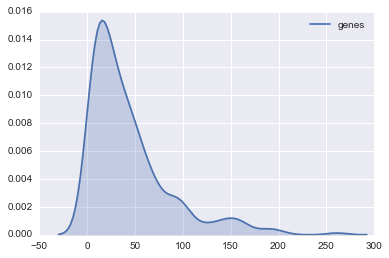

In [8]:
# Density plot of genes per pathway
seaborn.kdeplot(wikipath_df.genes.map(len), shade=True, );

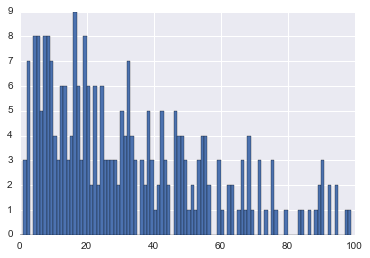

In [9]:
# Histogram of genes per pathway
plt.hist(list(wikipath_df.genes.map(len)), numpy.arange(100));
plt.xlim(0, 100);

## Parse MSigDB Pathways

In [10]:
gmt_generator = read_gmt('download/c2.cp.v5.1.entrez.gmt')
msigdb_df = pandas.DataFrame(gmt_generator, columns = ['name', 'description', 'genes'])
len(msigdb_df)

1330

In [11]:
# Remove genes absent from our entrez gene version
for genes in msigdb_df.genes:
    genes &= human_genes
msigdb_df = msigdb_df[msigdb_df.genes.map(bool)]
len(msigdb_df)

1330

In [12]:
msigdb_df.head()

,name,description,genes
0,KEGG_GLYCOLYSIS_GLUCONEOGENESIS,http://www.broadinstitute.org/gsea/msigdb/card...,"{5315, 229, 8789, 3948, 222, 5230, 5161, 5213,..."
1,KEGG_CITRATE_CYCLE_TCA_CYCLE,http://www.broadinstitute.org/gsea/msigdb/card...,"{8802, 47, 6392, 55753, 5161, 1737, 3419, 5091..."
2,KEGG_PENTOSE_PHOSPHATE_PATHWAY,http://www.broadinstitute.org/gsea/msigdb/card...,"{9563, 229, 8789, 51071, 5213, 226, 25796, 253..."
3,KEGG_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS,http://www.broadinstitute.org/gsea/msigdb/card...,"{7358, 7367, 10941, 2990, 79799, 7363, 27294, ..."
4,KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM,http://www.broadinstitute.org/gsea/msigdb/card...,"{229, 8789, 29926, 8898, 5210, 5213, 5207, 226..."


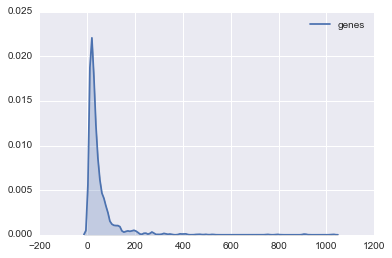

In [13]:
# Density plot of genes per pathway
seaborn.kdeplot(msigdb_df.genes.map(len), shade=True);

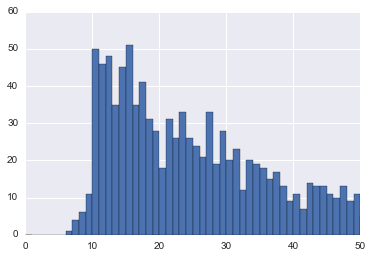

In [14]:
# Histogram of genes per pathway
plt.hist(msigdb_df.genes.map(len), numpy.arange(100));
plt.xlim(0, 50);

In [15]:
# MSigDB pathways per source database
# https://www.broadinstitute.org/gsea/msigdb/collection_details.jsp#CP
collections.Counter(msigdb_df.name.map(lambda x: x.split('_', 1)[0]))

Counter({'BIOCARTA': 217,
         'KEGG': 186,
         'NABA': 10,
         'PID': 196,
         'REACTOME': 674,
         'SA': 10,
         'SIG': 8,
         'ST': 28,
         'WNT': 1})

## Merge resources into a pathway dataframe

In [16]:
pathway_df = pandas.concat([
    pandas.DataFrame({
        'identifier': wikipath_df['description'].map(lambda x: x.rsplit('/', 1)[1]),
        'name': wikipath_df['name'],
        'url': wikipath_df['description'],
        'source': 'wikipathways',
        'license': 'CC-BY 3.0',
        'genes': wikipath_df.genes
    }),
    pandas.DataFrame({
        'identifier': msigdb_df['name'],
        'name': msigdb_df['name'],
        'url': msigdb_df['description'],
        'source': 'msigdb',
        'license': 'http://www.broadinstitute.org/cancer/software/gsea/wiki/index.php/License_info',
        'genes': msigdb_df.genes}),
])[['identifier', 'name', 'url', 'source', 'license', 'genes']]
len(pathway_df)

1626

In [17]:
# Remove duplicate pathways
pathway_df.genes = pathway_df.genes.map(frozenset)
pathway_df = pathway_df.drop_duplicates(['genes'])
len(pathway_df)

1624

In [18]:
pathway_df['coding_genes'] = pathway_df.genes.map(lambda x: x & human_coding_genes)

In [19]:
pathway_df.insert(3, 'n_genes', pathway_df.genes.map(len))
pathway_df.insert(4, 'n_coding_genes', pathway_df.coding_genes.map(len))

In [20]:
pathway_df = pathway_df.sort_values('identifier')
pathway_df.head()

,identifier,name,url,n_genes,n_coding_genes,source,license,genes,coding_genes
382,BIOCARTA_41BB_PATHWAY,BIOCARTA_41BB_PATHWAY,http://www.broadinstitute.org/gsea/msigdb/card...,17,17,msigdb,http://www.broadinstitute.org/cancer/software/...,"(11183, 5599, 3458, 1147, 3558, 4214, 3725, 35...","(4217, 1432, 3604, 11183, 5599, 3458, 4792, 11..."
199,BIOCARTA_ACE2_PATHWAY,BIOCARTA_ACE2_PATHWAY,http://www.broadinstitute.org/gsea/msigdb/card...,13,13,msigdb,http://www.broadinstitute.org/cancer/software/...,"(1284, 1286, 1215, 1287, 59272, 185, 5972, 163...","(1284, 1282, 1215, 1287, 59272, 185, 5972, 163..."
356,BIOCARTA_ACH_PATHWAY,BIOCARTA_ACH_PATHWAY,http://www.broadinstitute.org/gsea/msigdb/card...,16,16,msigdb,http://www.broadinstitute.org/cancer/software/...,"(4593, 356, 572, 5290, 207, 5294, 6714, 5913, ...","(4593, 2185, 5295, 5747, 356, 572, 5290, 1146,..."
402,BIOCARTA_ACTINY_PATHWAY,BIOCARTA_ACTINY_PATHWAY,http://www.broadinstitute.org/gsea/msigdb/card...,20,20,msigdb,http://www.broadinstitute.org/cancer/software/...,"(10096, 10093, 10109, 58, 8936, 10097, 10787, ...","(10810, 10096, 10093, 10109, 58, 5688, 8936, 1..."
205,BIOCARTA_AGPCR_PATHWAY,BIOCARTA_AGPCR_PATHWAY,http://www.broadinstitute.org/gsea/msigdb/card...,13,13,msigdb,http://www.broadinstitute.org/cancer/software/...,"(2782, 2792, 5577, 5575, 2778, 408, 5573, 5576...","(2782, 2792, 5577, 2778, 5575, 408, 5573, 5576..."


In [21]:
# Create a dataframe for writing as a tsv. Multi-element fields are pipe delimited.
write_df = pathway_df.copy()
join = lambda x: '|'.join(map(str, x))
for column in 'genes', 'coding_genes':
    write_df[column] = write_df[column].map(join)

write_df.to_csv('data/pathways.tsv', index=False, sep='\t')